# Test stable inverse CDF and parameter gradients of Kumaraswamy

Validating stable inverse CDF implementation

In [99]:
import torch
from torch.autograd import gradcheck
from torch.distributions import Kumaraswamy as torch_kumaraswamy_dist
from kumaraswamy import KumaraswamyStable, kumaraswamy_stable_inverse_cdf, kumaraswamy_stable_cdf, kumaraswamy_stable_log_pdf
log, exp = torch.log, torch.exp

import matplotlib.pyplot as plt
import numpy as np

### Numerical Gradient Verification
- Idea: To validate the gradients of the custom stable inverse CDF (and it's parameter gradients), we can compare the the naive pytorch implementation (which uses backprop to find the gradients). Since the naive pytorch implementation becomes unstable, we constrain ourselves to moderate values of $b$.
- To validate correctness below: 
    - Use float64 and $\log b < 25$ and 
    - inspect the inverse CDF and it's parameter gradient plots vs naive pytorch

Pytorch implemenation: https://pytorch.org/docs/stable/_modules/torch/distributions/kumaraswamy.html#Kumaraswamy

In [139]:
fit_shape = 'increasing'
if fit_shape == 'increasing':
    log_a_val, log_b_val = 1.5, -2
elif fit_shape == 'decreasing':
    log_a_val, log_b_val = -1, 1.5
elif fit_shape == 'bell':
    log_a_val, log_b_val = 4, 15 # produces noticable divergence
elif fit_shape == 'U':
    log_a_val, log_b_val = -85, -5 # we produce nan's around log_a_val = -90

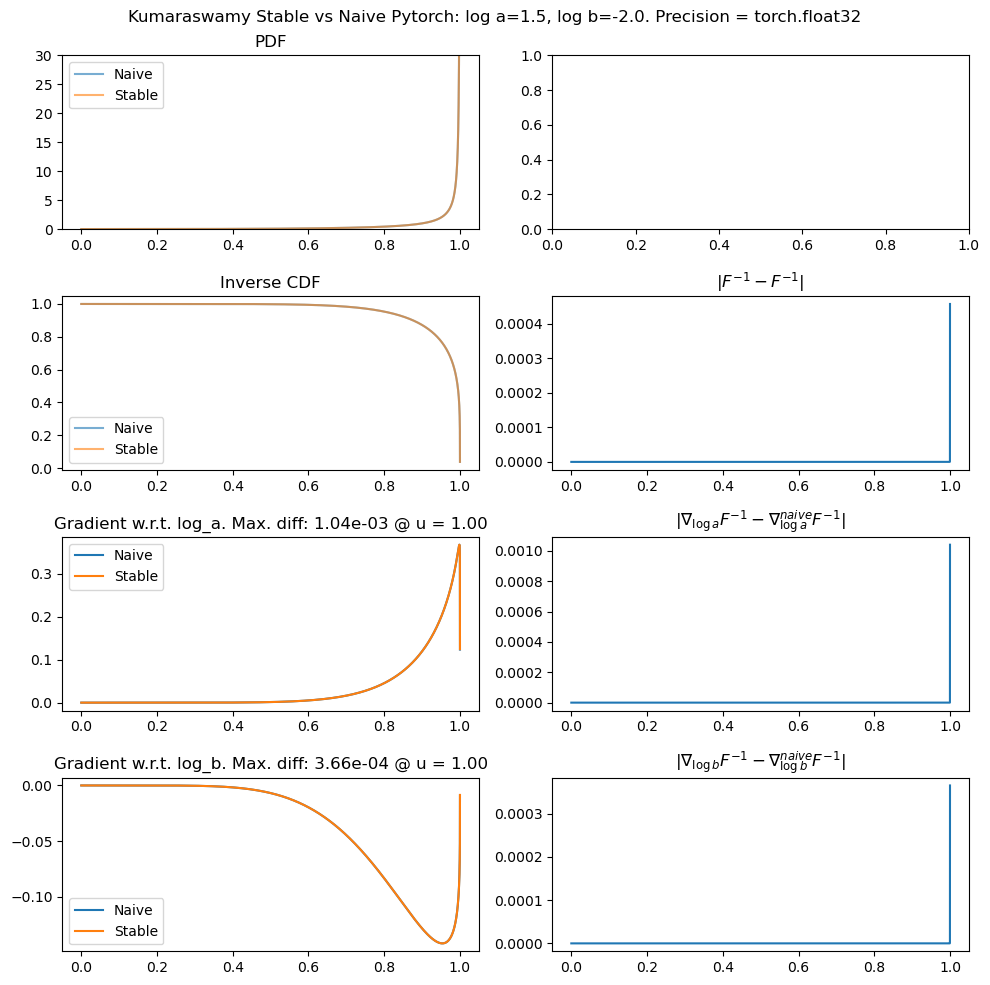

In [141]:
dtype = torch.float32 # THIS CHOICE IS IMPORTANT
eps = 2**-24

## Naive
u = torch.linspace(eps, 1-eps, steps=5000, requires_grad=False)
log_a = torch.tensor([log_a_val] * len(u), dtype=dtype, requires_grad=True)
log_b = torch.tensor([log_b_val] * len(u), dtype=dtype, requires_grad=True)

naive_pdf = torch.exp(torch_kumaraswamy_dist(log_a.exp(), log_b.exp()).log_prob(u)).detach().numpy()
naive_output = torch_kumaraswamy_dist(log_a.exp(), log_b.exp()).icdf(1-u)
naive_output.backward(torch.ones_like(naive_output))
naive_output, naive_log_a_grad, naive_log_b_grad = naive_output.detach().numpy(), log_a.grad.detach().numpy(), log_b.grad.detach().numpy()

## Custom
u = torch.linspace(eps, 1-eps, steps=5000, requires_grad=False)
log_a = torch.tensor([log_a_val] * len(u), dtype=dtype, requires_grad=True)
log_b = torch.tensor([log_b_val] * len(u), dtype=dtype, requires_grad=True)

custom_pdf = torch.exp(kumaraswamy_stable_log_pdf(u, log_a, log_b)).detach().numpy()
custom_output = kumaraswamy_stable_inverse_cdf(u, log_a, log_b)
custom_output.backward(torch.ones_like(custom_output))
custom_output, custom_log_a_grad, custom_log_b_grad = custom_output.detach().numpy(), log_a.grad.detach().numpy(), log_b.grad.detach().numpy()


# make a plot of output, log_a_grad, log_b_grad vs u for each
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

fig.suptitle(f"Kumaraswamy Stable vs Naive Pytorch: log a={log_a_val:.1f}, log b={log_b_val:.1f}. Precision = {dtype}")

i = 0
if fit_shape == 'U':
    # include more information in title when U shape
    log_a_single = torch.tensor([log_a_val])
    log_b_single = torch.tensor([log_b_val])

    bad_prob = kumaraswamy_stable_cdf(torch.tensor(.95), log_a_single, log_b_single) - kumaraswamy_stable_cdf(torch.tensor(.05), log_a_single, log_b_single)
    p_lt_05 = kumaraswamy_stable_cdf(torch.tensor(.05), log_a_single, log_b_single)
    p_gt_95 = 1 - kumaraswamy_stable_cdf(torch.tensor(.95), log_a_single, log_b_single)
    axs[i, 0].set_title(f"PDF. Stable Bad prob: {bad_prob.item():.2f}, p < .05: {p_lt_05.item():.2f}, p > .95: {p_gt_95.item():.2f}")
    
axs[i, 0].plot(u, naive_pdf, alpha=0.6, label="Naive")
axs[i, 0].plot(u, custom_pdf, alpha=0.6, label="Stable")
# set y-lim to be a max of 30 if if it above 30
if np.max(custom_pdf) > 30 or np.max(naive_pdf) > 30:
    axs[i, 0].set_ylim(0, 30)
if fit_shape != "U":
    axs[i, 0].set_title(f"PDF")
axs[i, 0].legend()

i += 1
axs[i, 0].plot(u, naive_output, alpha=0.6, label="Naive")
axs[i, 0].plot(u, custom_output, alpha=0.6, label="Stable")
axs[i, 0].set_title(f"Inverse CDF")
axs[i, 0].legend()

axs[i, 1].plot(u, np.abs(naive_output - custom_output))
axs[i, 1].set_title("Difference between Naive and Stable")
axs[i, 1].set_title(r"$| F^{-1} - F^{-1} |$")

i += 1
axs[i, 0].plot(u, naive_log_a_grad, label="Naive")
axs[i, 0].plot(u, custom_log_a_grad, label="Stable")
# find max difference and the corresponding u
max_diff = np.max(np.abs(naive_log_a_grad - custom_log_a_grad))
arg_max_diff = np.argmax(np.abs(naive_log_a_grad - custom_log_a_grad))
axs[i, 0].set_title(f"Gradient w.r.t. log_a. Max. diff: {max_diff:.2e} @ u = {u[arg_max_diff]:.2f}")
axs[i, 0].legend()

axs[i, 1].plot(u, np.abs(naive_log_a_grad - custom_log_a_grad))
axs[i, 1].set_title(r"$|\nabla_{\log a} F^{-1} - \nabla_{\log a}^{naive} F^{-1}|$")

i += 1
axs[i, 0].plot(u, naive_log_b_grad, label="Naive")
axs[i, 0].plot(u, custom_log_b_grad, label="Stable")
max_diff = np.max(np.abs(naive_log_b_grad - custom_log_b_grad))
arg_max_diff = np.argmax(np.abs(naive_log_b_grad - custom_log_b_grad))
axs[i, 0].set_title(f"Gradient w.r.t. log_b. Max. diff: {max_diff:.2e} @ u = {u[arg_max_diff]:.2f}")
axs[i, 0].legend()

axs[i, 1].plot(u, np.abs(naive_log_b_grad - custom_log_b_grad))
axs[i, 1].set_title(r"$|\nabla_{\log b} F^{-1} - \nabla_{\log b}^{naive} F^{-1}|$")

plt.tight_layout()

plt.show()


# Below: Old, but useful example of full broadcasting/reshaping of u and log_a/log_b for gradiients.

/var/folders/lk/qxmfz0hx2ggd8m2__sd2ks9h0000gn/T/ipykernel_6244/1439505595.py:46: RuntimeWarning: divide by zero encountered in log
  grad_log_a = np.log(np.abs(grad_log_a))
/var/folders/lk/qxmfz0hx2ggd8m2__sd2ks9h0000gn/T/ipykernel_6244/1439505595.py:47: RuntimeWarning: divide by zero encountered in log
  grad_log_b = np.log(np.abs(grad_log_b))


x,      F^{-1}(x), nabla_{log a} F^{-1}, log |nabla_{log a} F^{-1}|, nabla_{log_b} F^{-1}, log |nabla_{log b} F^{-1}|
0.000,  1.000,        0.000, -inf,     0.000        -inf
0.001,  1.000,        0.000, -53.034,     0.000        -49.102
0.002,  1.000,        0.000, -47.913,     0.000        -44.086
0.003,  1.000,        0.000, -44.917,     0.000        -41.157
0.004,  1.000,        0.000, -42.791,     0.000        -39.083
0.005,  1.000,        0.000, -41.142,     0.000        -37.475
0.006,  1.000,        0.000, -39.795,     0.000        -36.163
0.007,  1.000,        0.000, -38.656,     0.000        -35.054
0.008,  1.000,        0.000, -37.669,     0.000        -34.095
0.009,  1.000,        0.000, -36.799,     0.000        -33.249
0.010,  1.000,        0.000, -36.020,     0.000        -32.494
0.011,  1.000,        0.000, -35.316,     0.000        -31.810
0.012,  1.000,        0.000, -34.673,     0.000        -31.187
0.013,  1.000,        0.000, -34.082,     0.000        -30.614
0.014,

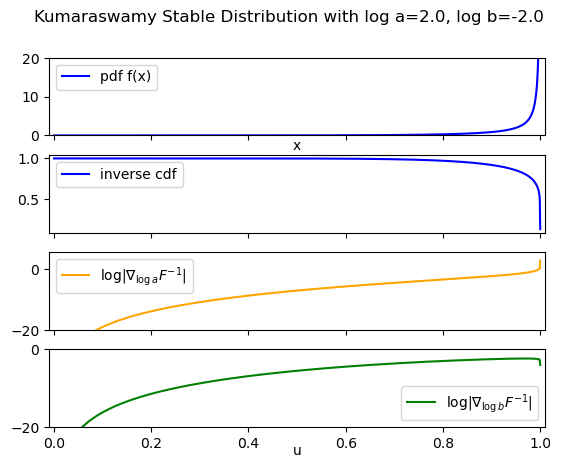

In [57]:
fit_shape = 'increasing'
if fit_shape == 'increasing':
    log_a_value, log_b_value = 2, -2
elif fit_shape == 'decreasing':
    log_a_value, log_b_value = -1, 3
elif fit_shape == 'bell':
    log_a_value, log_b_value = 4, 30
elif fit_shape == 'U':
    # note: log_a will be fixed for bernoulli relaxation, so not concerned about diverging \nabla_{\log a}
    log_a_value, log_b_value = -5, -1 

# Set up a range of x values
eps = 2**-24
u_values = torch.linspace(0, 1-eps, steps=1000, dtype=torch.double, requires_grad=True) # x in (0, 1) handled internally

# These must be reshaped so we can compute gradient over EACH u value.
log_a = torch.ones((len(u_values), 1), dtype=torch.double, requires_grad=True)
log_b = torch.ones((len(u_values), 1), dtype=torch.double, requires_grad=True)

### SPECIFY SHAPE of KS ###
#log_a_value = -5 #.25
#log_b_value = -2.5 #.5

# Set log_a and log_b to uniform values
log_a = torch.full((len(u_values), 1), log_a_value, dtype=torch.double, requires_grad=True)
log_b = torch.full((len(u_values), 1), log_b_value, dtype=torch.double, requires_grad=True)

u_values_broadcasted = u_values.view(-1, 1)

# Compute the inverse CDF
inverse_cdf = kumaraswamy_stable_inverse_cdf(u_values_broadcasted, log_a, log_b)
np_inverse_cdf = inverse_cdf.detach().numpy()

# Compute the gradient with respect to log_a for each u value
inverse_cdf.backward(torch.ones_like(u_values_broadcasted), retain_graph=True)

# Collect the gradient values
grad_log_a = log_a.grad.view(-1).detach().numpy()
grad_log_b = log_b.grad.view(-1).detach().numpy()

raw_grad_log_a = grad_log_a
raw_grad_log_b = grad_log_b

use_log_magnitude = True
if use_log_magnitude:
    grad_log_a = np.log(np.abs(grad_log_a))
    grad_log_b = np.log(np.abs(grad_log_b))

print(r"x,      F^{-1}(x), nabla_{log a} F^{-1}, log |nabla_{log a} F^{-1}|, nabla_{log_b} F^{-1}, log |nabla_{log b} F^{-1}|")
for i, (x, inverse_cdf_vals, rgl_a, gl_a, rgl_b, gl_b) in enumerate(zip(u_values, inverse_cdf.detach().numpy(), raw_grad_log_a, grad_log_a, raw_grad_log_b, grad_log_b, )):
    print(f"{x:.3f},  {inverse_cdf_vals.item():.3f},        {rgl_a:.3f}, {gl_a:.3f},     {rgl_b:.3f}        {gl_b:.3f}")


# Plot the inverse cdf and its gradient
fig, axs = plt.subplots(4)
# title
fig.suptitle(f"Kumaraswamy Stable Distribution with log a={log_a_value:.1f}, log b={log_b_value:.1f}")
log_pdf = kumaraswamy_stable_log_pdf(u_values_broadcasted, log_a, log_b)
np_log_pdf = log_pdf.detach().numpy()
pdf = np.exp(np_log_pdf)
axs[0].plot(u_values.detach().numpy(), np.exp(log_pdf.detach().numpy()), label="pdf f(x)", color='blue')
# move xlable closer to axis
axs[0].set_xlabel("x", labelpad=-5)
if pdf.max() > 20:
    axs[0].set_ylim(0, 20)
axs[0].set_xlim(-1e-2, 1+1e-2)
axs[0].legend()


inverse_cdf = inverse_cdf.detach().numpy()
axs[1].plot(u_values.detach().numpy(), inverse_cdf, label="inverse cdf", color='blue')
axs[1].set_xlim(-1e-2, 1+1e-2)
axs[1].legend()

axs[2].plot(u_values.detach().numpy(), 
            grad_log_a, 
            label=r"$\log |\nabla_{\log a} F^{-1}|$", color='orange')
axs[2].set_xlim(-1e-2, 1+1e-2)
axs[2].legend()
# set lower limit to -10, keep upper limit the same
y_min = max(-20, axs[2].get_ylim()[0])
y_max = min(20, axs[2].get_ylim()[1])
axs[2].set_ylim(y_min, y_max)

axs[3].plot(u_values.detach().numpy(), 
            grad_log_b, 
            label=r"$\log |\nabla_{\log b} F^{-1}|$", color='green')
axs[3].set_xlabel("u", labelpad=-5)
axs[3].set_xlim(-1e-2, 1+1e-2)
# y min is the maximum of -20 and the current min
y_min = max(-20, axs[3].get_ylim()[0])
y_max = min(20, axs[3].get_ylim()[1])
axs[3].set_ylim(y_min, y_max)

axs[3].legend()

# remove x tick labels from all but last
for ax in axs[:-1]:
    ax.set_xticklabels([])

# separate subplot 0 and 1 vertically
fig.subplots_adjust(hspace=.25)